In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [4]:
from implementations import *

### Data pre-processing 

In [5]:
# remove categorical data
tX = np.delete(tX, 22, axis=1)
# keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX, degree = 1, cutoff = 0.1, 
                      imputation = impute_median, interaction = True)
# standarize the data
rmX = np.append(rmX, 22)
tX = np.apply_along_axis(standardize, 1, tX)

In [15]:
#y = np.where(y==-1, 0, y)
#y = np.where(y==0, -1, y)
#tX = tX[0:100, :]
#y = y[0:100]

In [6]:
print(tX.shape)
print(rmX)

(250000, 172)
[ 0  4  5  6 12 22 23 24 25 26 27 22]


### Exploratory analysis

### Feature processing

**Least squares**

In [17]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[-70.5981302  -16.78513583 -17.25214872 -17.49145543 -16.74646707
   2.72024594 -17.06377834 -36.62250524 -25.79823867 -14.21701321
   3.67518699 -17.28516961 -16.57547079   3.46043417 -16.34701504
 -16.96278144 -16.7325343  -17.25656422 -16.93948521 -16.83452624
 -16.51797407 -17.01090294   2.78899283]

mse=0.33660197234865225


**Least squares with Gradient Descent**

In [18]:
#define parameters

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

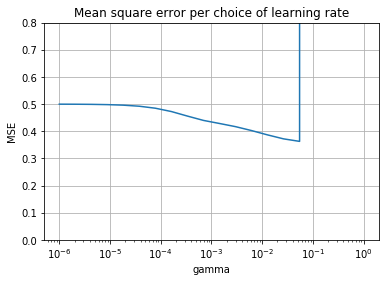

In [19]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [20]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w* =[ 0.0261578   0.07123164 -0.43455337 -0.04040413  0.10137394  0.02987276
 -0.05229008  0.04438637  0.01701713  0.0400476   0.20707006  0.02756007
  0.03117205 -0.08052893  0.02857063  0.02765407 -0.04288854  0.02325758
 -0.05949462  0.00272686  0.02878583  0.02882604 -0.02555078]

mse=0.36286316465046436

gamma=0.05455594781168514


**Least squares with Stochastic Gradient Descent**

In [21]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

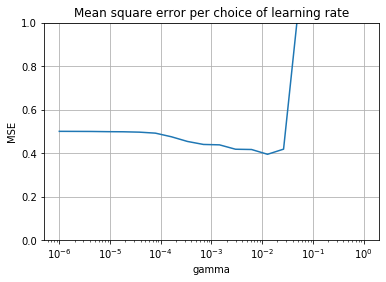

In [22]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [23]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

w* =[ 0.024389    0.08611909 -0.25523463  0.04373614  0.0317806   0.02653036
 -0.05826445 -0.01348284  0.02122614  0.0289998   0.04648188  0.02359333
  0.02782502 -0.01888828  0.02562708  0.01942069  0.01440029  0.01926689
 -0.06865433 -0.08056157  0.02532697  0.02093106  0.00943178]

mse=0.3942071769726438

gamma=0.012742749857031322


**Ridge regression**

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation and bias-variance decomposition respectively. 

As the two are interdependent, we can just run them in a loop (each cells after the others, so first the cross-validation, then biais-variance decomposition, again cross-validation, etc.) to have the best parameters. 

***Cross-validation hyperparameter selection***

In [8]:
seed = 1
degree_ri = 7
k_fold = 4
lambdas = np.logspace(-12, 0, 20)
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True)

Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed degree 8/8
Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed degree 8/8
Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed degree 8/8
Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed degree 8/8
Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed degree 8/8
Completed degree 1/8
Completed degree 2/8
Completed degree 3/8
Completed degree 4/8
Completed degree 5/8
Completed degree 6/8
Completed degree 7/8
Completed deg

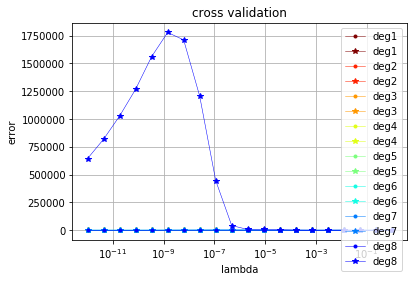

In [9]:
cross_validation_visualization(degrees, rmse_tr_ri, rmse_te_ri, lambdas)

In [10]:
idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

lambda*=1e-12

degree*=4

rmse train=0.2903318961168044

rmse test=0.29288330444692423


***Bias-variance decomposition for complexity determination***

In [12]:
def bias_variance_decomposition_visualization(degrees, loss_tr, loss_te):
    """visualize the bias variance decomposition."""
    loss_tr_mean = np.expand_dims(np.mean(loss_tr, axis=0), axis=0)
    loss_te_mean = np.expand_dims(np.mean(loss_te, axis=0), axis=0)
    plt.plot(degrees, loss_tr.T, 'b', linestyle="-", label='train', linewidth=0.3)
    plt.plot(degrees, loss_te.T, 'r', linestyle="-", label='test', linewidth=0.3)
    plt.plot(degrees, loss_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, loss_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.ylim(0, 10)
    plt.title("Bias-Variance Decomposition")

In [13]:
ratio_train = 0.1
seeds = range(50)

In [14]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*mse_tr)
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*mse_te)

KeyboardInterrupt: 

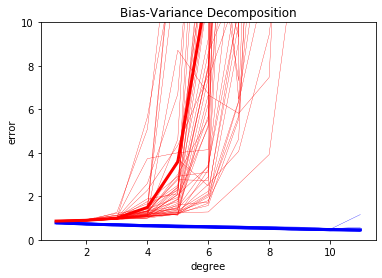

In [81]:
bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

Based on the plot above, change the value of `degree_ri` manually. 

In [82]:
rmse_te_bv = np.array(rmse_te_bv)
rmse_tr_bv = np.array(rmse_tr_bv)

idx = np.nanargmin(np.abs(np.mean(rmse_te_bv-rmse_tr_bv, axis=0)))

degree_ri = degree_ri

print("degree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx].mean(), rmse_te=rmse_te_bv[idx].mean()))

degree*=4

rmse train=0.5600573240803647

rmse test=40.12414734237051


In [11]:
tX_poly = build_poly(tX, degree_ri)
            
w_ri, mse_ri = ridge_regression(y, tX_poly, lambda_ri)

print("final w* shape={w}\n\nfinal degree*={degree}\n\nfinal lambda*={lambda_}\n\nmse={loss}".format(w=w_ri.shape, \
            degree=degree_ri, lambda_=lambda_ri, loss = mse_ri))

final w* shape=(689,)

final degree*=4

final lambda*=1e-12

mse=0.290576334597526


**Logistic regression**

In [84]:
y = np.where(y==-1, 0, y)
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)

In [85]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(y, tX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:55: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


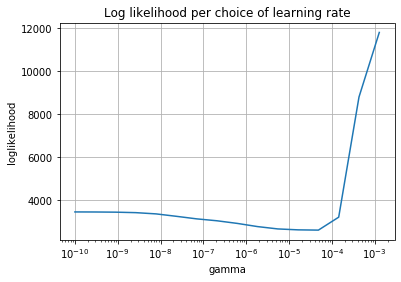

In [86]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [87]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

w* =[ 0.07176855  0.43254268 -1.4126755  -0.66552498  0.29838723  0.1657619
 -0.41394665  0.32898223  0.00579805  0.24755313  1.24997118  0.09464347
  0.1680774  -0.32298718  0.12058937  0.08554498 -0.07920989 -0.00398086
 -0.1414511  -0.07665783  0.12196869  0.11260934 -0.3877642 ]

loglikelihood loss=2619.1446297525777

gamma=4.8329302385717524e-05


***Cross-validation for hyperparameter determination***

In [105]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas=[0], ml_function = 'lr', max_iters = 1000, gamma = gamma_lr)

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:55: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


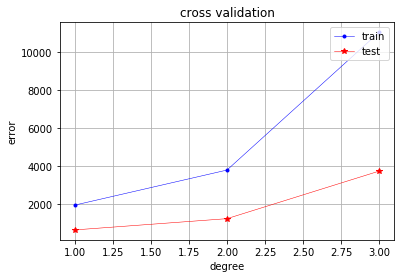

In [115]:
cross_validation_visualization(degrees, loss_tr_lr, loss_te_lr)

In [120]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmin(loss_te_lr)

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}".format(
    degree=degree_ri, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx]))

degree*=4

loglikelihood train=nan

loglikelihood test=nan


**Regularized logistic regression**

In [121]:
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
lambda_rlr =lambda_ri

In [122]:
losses_rlr = np.empty(len(gammas))
ws_rlr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = reg_logistic_regression(y, tX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr[idx] = loss
    ws_rlr[idx, :] = w

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:55: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


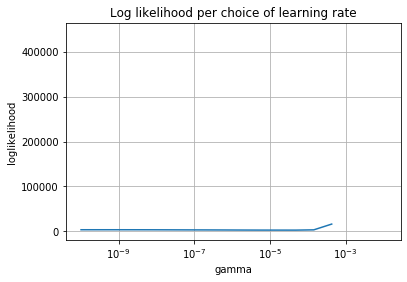

In [123]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [124]:
idx = np.nanargmin(losses_rlr)

w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=losses_rlr[idx], gamma = gamma_rlr))

w* =[ 0.07176855  0.43254268 -1.4126755  -0.66552498  0.29838723  0.1657619
 -0.41394665  0.32898223  0.00579805  0.24755313  1.24997118  0.09464347
  0.1680774  -0.32298718  0.12058937  0.08554498 -0.07920989 -0.00398086
 -0.1414511  -0.07665783  0.12196869  0.11260934 -0.3877642 ]

loglikelihood loss=2619.1446297525777

gamma=4.8329302385717524e-05


***Cross-validation hyperparameter selection***

In [125]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-12, 0, 10)
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

In [126]:
loss_tr_rlr, loss_te_rlr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas, ml_function = 'lr', max_iters = 1000, gamma = gamma_rlr)

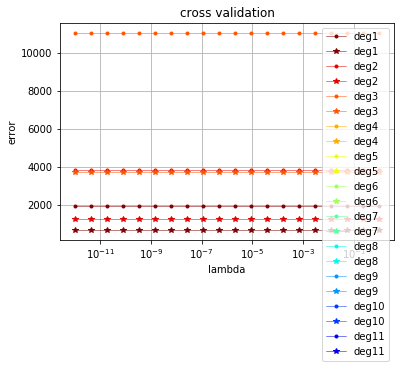

In [147]:
cross_validation_visualization(degrees, loss_tr_rlr, loss_te_rlr, lambdas)

In [148]:
idx = np.unravel_index(np.nanargmin(loss_te_rlr), loss_te_rlr.shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("lambda* ={lambda_}n\ndegree*={degree}\n\nloglikelihood train={log_tr}\n\nloglikelihood test={log_te}".format(
    lambda_=lambda_rlr, degree=degree_rlr, log_tr=loss_tr_rlr[idx], log_te=loss_te_rlr[idx]))

lambda* =1e-12n
degree*=1

loglikelihood train=1958.9876682290392

loglikelihood test=654.7972342018161


***Bias-variance decomposition for complexity determination***

In [149]:
ratio_train = 0.1
seeds = range(50)
degrees = range(1, 9)
lambda_rlr = lambda_ri

In [150]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        

    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:55: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


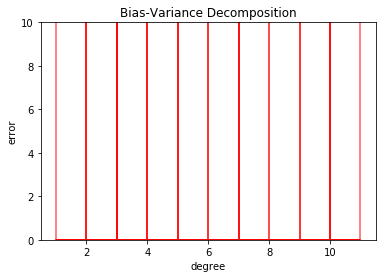

In [151]:
bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

Based on the plot above, change the value of `degree_rlr` manually. 

In [152]:
loss_te_bv = np.array(loss_te_bv)
loss_tr_bv = np.array(loss_tr_bv)

idx = np.nanargmin(np.nanmean(loss_tr_bv, axis=1))

degree_rlr = 4
lambda_rlr = 1.8329807108324375e-11

print("degree* ={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}".format(
    degree=degree_rlr, loss_tr=np.nanmean(loss_tr_bv[idx]), loss_te=np.nanmean(loss_te_bv[idx])))

degree* =4

loglikelihood train=2706.508149037536

loglikelihood test=3.3235844527509454e+232


In [153]:
tX_poly = build_poly(tX, degree_rlr)
initial_w = np.empty(tX_poly.shape[1])            
w_rlr, log_rlr = reg_logistic_regression(y, tX_poly, lambda_rlr, initial_w, max_iters, gamma_rlr)

print("final w* shape={w}\n\nfinal degree*={degree}\n\nfinal lambda*={lambda_}\n\nlog-likelihood={loss}".format(w=w_rlr.shape, \
            degree=degree_rlr, lambda_=lambda_rlr, loss = log_rlr))

final w* shape=(93,)

final degree*=4

final lambda*=1.8329807108324375e-11

log-likelihood=nan


### Overfitting vs Underfitting

### Methods application and visualization

In [154]:
#save the calculated variables to keep them without having to re-run everything
# w_ls, w_gd, gamma_gd, w_sgd, gamma_sgd, w_ri, degree_ri, lambda_ri
# w_lr, gamma_lr, w_rlr, gamma_rlr, lambda_rlr, degree_rlr
ws = (w_ls, w_gd, w_sgd, w_ri, w_lr, w_rlr)
degs = (degree_ri , degree_rlr)
gammas = (gamma_gd, gamma_sgd, gamma_lr, gamma_rlr)
lambdas = (lambda_ri, lambda_rlr)

np.savetxt('weights.txt', ws, fmt='%s', delimiter=',', newline='\n')
np.savetxt('degrees.txt', degs, fmt='%s', delimiter=',', newline='\n')
np.savetxt('gammas.txt', gammas, fmt='%s', delimiter=',', newline='\n')
np.savetxt('lambdas.txt', lambdas, fmt='%s', delimiter=',', newline='\n')

## Generate predictions and save ouput in csv format for submission:

In [155]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [156]:
weights = w_ri
#weights = np.insert(weights, rmX, 0, axis = 0)
tX_test = np.delete(tX_test, rmX, axis=1)
# keep only columns that do not have too much missing data
tX_test, rmX_test = train_data_formatting(tX_test, degree = 1, cutoff = 1.0, 
                      imputation = impute_median, interaction = False)
tX_test = np.apply_along_axis(standardize, 1, tX_test)
tX_poly = build_poly(tX_test, 7)

print(tX_test.shape)
print(weights.shape)
print(tX_poly.shape)

(568238, 23)
(93,)
(568238, 162)


In [ ]:
OUTPUT_PATH = '../data/sample-submission.csv'
y_pred = predict_labels(weights, tX_poly)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)